In [56]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import copy
import torchvision.models as models
import torch.nn as nn
from clustimage import Clustimage
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image
import pandas as pd
from os import listdir
from sklearn.metrics import pairwise_distances_argmin_min
 
from os.path import isfile, join


PyTorch version: 2.3.0.dev20231230+rocm5.7
Torchvision version: 0.18.0.dev20231230+rocm5.7
CUDA is available: True


# Load models

In [48]:
cl = Clustimage(method='pca',embedding='tsne',dirpath='./out',store_to_disk=True, dim=(256, 256), params_pca={'n_components':0.95})
cl.load(filepath='./out/backup_clustimage.pkl')
results = cl.results

classes = np.unique(results['labels'])
k = len(classes)

[clustimage] >INFO> filepath is set to [/home/julien/Documents/code/HackQC-AI/out]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]


[pypickle] Pickle file loaded: [./out/backup_clustimage.pkl]


[clustimage] >INFO> Load succesful!


In [49]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels, transformations = None, original:bool = False):
        super(CustomImageDataset, self).__init__()
        self.img_list = img_list
        self.labels = labels
        self.og = original
        self.transformations = transformations

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_filepath = self.img_list[idx]
        og_filepath = image_filepath.replace("modv2_moncouche_HD", "moncouche_HD").replace("SAM_", "")
        image = torchvision.io.read_image(image_filepath) if self.og==False else torchvision.io.read_image(og_filepath)
        resize = torchvision.transforms.Resize((256,256))
       
        image = resize(image)
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transformations is not None:
            image = self.transformations(image=image)["image"]
        
        lab = self.labels[idx]
        return image, torch.tensor(lab, dtype=torch.float32)

In [50]:


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)  # Update input channels to 1
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.05)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(524288, 512)  # Adjust input size based on image dimensions
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.05)
        self.fc4 = nn.Linear(512, 256)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(256, num_classes)
        
        self.act5 = nn.Sigmoid()
        
 
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        #x = torch.nn.Linear(x.shape[1], 512)(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        
        return x
        
        
        



# Import validation dataset

In [51]:
path_test_dir= '../test_phase_moncouche/'
path_new_image = path_test_images= '../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_08_07_00_23.jpg'
all_images = [f for f in listdir(path_test_dir) if isfile(join(path_test_dir, f))]


# Find cluster with similarity analysis:

In [52]:
def find_similarity_analysis(image_path, cl, metric, k, alpha=0.05):
    results_find = cl.find(Xnew =image_path, metric = metric, k=k, alpha=alpha)
    
    # Show whatever is found. This looks pretty good.
    cl.plot_find()
    # Extract the first input image name
    filename = [*results_find.keys()][1]
    # Extract the cluster labels for the input image
    results_find[filename]['labels']

    # The majority of labels 
    label = pd.value_counts(results_find[filename]['labels'])
    print(label)
    
    percentage_clust = (label/np.sum(label)).to_dict()
    
    return percentage_clust

In [53]:
results_find = cl.find(Xnew =path_new_image, metric = 'euclidean', k=k, alpha=0.05)

[clustimage] >INFO> Find similar images with metric [euclidean], k-nearest neighbors: 6 and under alpha: 0.05 
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
[clustimage]: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


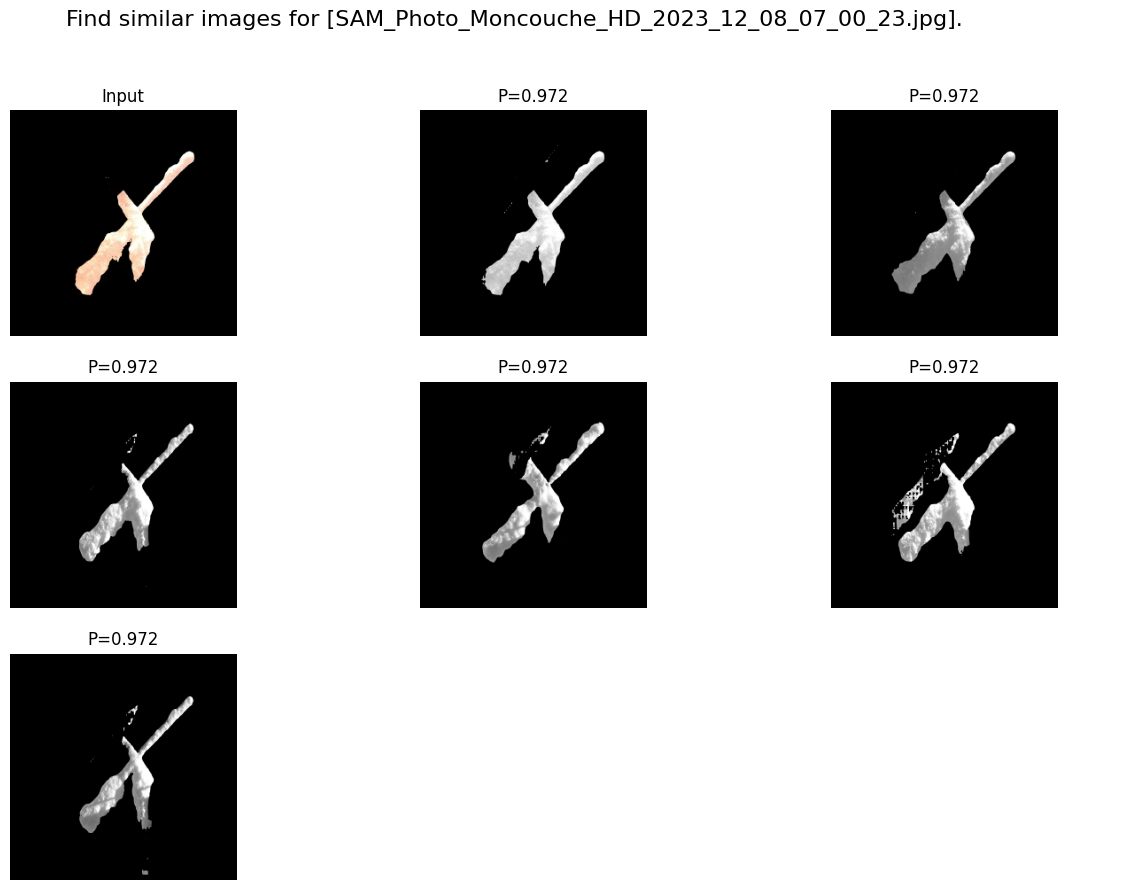

labels
 4    3
 2    2
-1    1
Name: count, dtype: int64


In [7]:
# Show whatever is found. This looks pretty good.
cl.plot_find()
# Extract the first input image name
filename = [*results_find.keys()][1]
# Extract the cluster labels for the input image
results_find[filename]['labels']

# The majority of labels is for class 0
label = pd.value_counts(results_find[filename]['labels'])
print(label)

In [54]:
percentage_clust = (label/np.sum(label)).to_dict()
print(percentage_clust)

{4: 0.5, 2: 0.3333333333333333, -1: 0.16666666666666666}


# Find cluster with SSIM analysis with the picture closest to the centroid of each cluster

In [55]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [57]:
def find_SSIM_Centroid(path_new_image, cl):
    new_image = cv2.imread(path_new_image) 
    img_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    results = cl.results
    ssim_dic = {}
    #centroid_list = []
    for i in classes:
        mask = results['labels'] == i
        points = results['xycoord'][mask]
        pics = results['pathnames'][mask]
        centroid = np.array([centeroidnp(points)])
        
        cl2, dst2 = pairwise_distances_argmin_min(centroid, points)
        print(pics[cl2][0])
        
        image = cv2.imread(str(pics[cl2][0]), cv2.COLOR_BGR2GRAY)
        #cv2.imshow('fen',image)
        #cv2.waitKey(0)
        #centroid_list += [[i, centroid, pics[cl2], image]]
        
        
        (score, diff) = compare_ssim(img_gray, image, full=True, gaussian_weights=True)
        ssim_dic[f"{i}"] = score
        #diff = (diff * 255).astype("uint8")
        print(f"cluster: {i}")
        print("SSIM: {}".format(score)) # expected
    return ssim_dic

In [10]:


new_image = cv2.imread(path_new_image) 
img_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

ssim_dic = {}
#centroid_list = []
for i in classes:
    mask = results['labels'] == i
    points = results['xycoord'][mask]
    pics = results['pathnames'][mask]
    centroid = np.array([centeroidnp(points)])
    
    cl2, dst2 = pairwise_distances_argmin_min(centroid, points)
    print(pics[cl2][0])
    
    image = cv2.imread(str(pics[cl2][0]), cv2.COLOR_BGR2GRAY)
    #cv2.imshow('fen',image)
    #cv2.waitKey(0)
    #centroid_list += [[i, centroid, pics[cl2], image]]
    
    
    (score, diff) = compare_ssim(img_gray, image, full=True, gaussian_weights=True)
    ssim_dic[f"{i}"] = score
    #diff = (diff * 255).astype("uint8")
    print(f"cluster: {i}")
    print("SSIM: {}".format(score)) # expected

../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/julien/.local/lib/python3.10/site-packages/cv2/qt/plugins"


cluster: -1
SSIM: 0.8956594020620396
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_31_10_00_22.jpg
cluster: 0
SSIM: 0.9236526928523232
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_06_04_00.jpg
cluster: 1
SSIM: 0.673714392083606
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: 2
SSIM: 0.9177311689678445
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 3
SSIM: 0.9181244730723128
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_21_11_00_23.jpg
cluster: 4
SSIM: 0.9257315495839019


In [11]:
print(ssim_dic['3'])

0.9181244730723128


# Find cluster with CNN

In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
my_model = CNN(num_classes=6).to(device)
my_model.load_state_dict(torch.load("OurCNN.pth"))
my_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.05, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=524288, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.05, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (act4): ReLU()
  (fc5): Linear(in_features=256, out_features=6, bias=True)
  (act5): Sigmoid()
)

In [13]:

og_filepath = "../moncouche_HD/Photo_Moncouche_HD_2023_12_08_07_00_23.jpg"
image = torchvision.io.read_image(og_filepath) 
print(image)
resize = torchvision.transforms.Resize((256,256))

image = resize(image)
image_tensor = torch.tensor(image, dtype=torch.float32)
image_tensor = image_tensor.to(device).float().unsqueeze(0)
print(image_tensor.shape) # must be of shape torch.Size([1, 3, 256, 256])
print(image_tensor)

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [120, 134, 144,  ..., 155, 144, 127],
         [ 91, 113, 130,  ..., 170, 167, 154],
         ...,
         [ 16,  16,  16,  ...,  16,  16,  16],
         [ 16,  16,  16,  ...,  16,  16,  16],
         [ 16,  16,  16,  ...,  16,  16,  16]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [160, 165, 160,  ..., 195, 189, 173],
         [157, 172, 173,  ..., 202, 201, 190],
         ...,
         [ 16,  16,  16,  ...,  16,  16,  16],
         [ 16,  16,  16,  ...,  16,  16,  16],
         [ 16,  16,  16,  ...,  16,  16,  16]],

        [[135, 130, 115,  ..., 121, 133, 130],
         [245, 247, 235,  ..., 247, 246, 232],
         [192, 206, 205,  ..., 243, 247, 238],
         ...,
         [ 16,  16,  16,  ...,  16,  16,  16],
         [ 16,  16,  16,  ...,  16,  16,  16],
         [ 16,  16,  16,  ...,  16,  16,  16]]], dtype=torch.uint8)
torch.Size([1, 3, 256, 256])
tensor([[[[115., 118., 111.,  ..., 125., 125., 135.],
    

In [14]:

pred_CNN = my_model.forward(image_tensor)

In [15]:
pred_CNN = (pred_CNN.detach().cpu().numpy())

# Voting

In [17]:
vote = {}
count = 0
for elem in classes:
    vote[f'{elem}'] = (percentage_clust[f'{elem}'] if f'{elem}' in percentage_clust.keys() else 0) + (ssim_dic[f'{elem}'] if f'{elem}' in ssim_dic.keys() else 0) + pred_CNN[:,count]
    count += 1

In [26]:
print(vote)

{'-1': array([0.92927873], dtype=float32), '0': array([0.9310051], dtype=float32), '1': array([0.6738555], dtype=float32), '2': array([1.6009681], dtype=float32), '3': array([0.9181317], dtype=float32), '4': array([1.8712682], dtype=float32)}


In [25]:
print(max(vote, key=vote.get))

4
